In [2]:
# Включване на нужните библиотеки
# Including libraries

import random
import numpy as np
import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from IPython.display import Image

In [3]:
# Зареждаме корпуса
# Loading the corpus

text = open("datasets/chalga.txt").read().decode('utf-8')
print("Corpus length: " + str(len(text)))

Corpus length: 196289


In [4]:
# Взимаме сортирани всички уникални 'char'-ове
# We're getting all unique chars sorted

chars = sorted(list(set(text))) # 

print("All characters: ")
print(chars)

All characters: 
[u'\n', u' ', u'!', u'"', u'&', u"'", u'(', u')', u'*', u',', u'-', u'.', u'/', u'0', u'1', u'2', u'3', u'5', u'6', u'7', u'8', u'9', u':', u'?', u'B', u'C', u'D', u'F', u'G', u'H', u'I', u'J', u'K', u'M', u'N', u'O', u'P', u'R', u'S', u'T', u'V', u'W', u'_', u'a', u'b', u'c', u'd', u'e', u'f', u'g', u'h', u'i', u'j', u'k', u'l', u'm', u'n', u'o', u'p', u'q', u'r', u's', u't', u'u', u'v', u'w', u'x', u'y', u'\xeb', u'\u0410', u'\u0411', u'\u0412', u'\u0413', u'\u0414', u'\u0415', u'\u0416', u'\u0417', u'\u0418', u'\u0419', u'\u041a', u'\u041b', u'\u041c', u'\u041d', u'\u041e', u'\u041f', u'\u0420', u'\u0421', u'\u0422', u'\u0423', u'\u0424', u'\u0425', u'\u0426', u'\u0427', u'\u0428', u'\u0429', u'\u042a', u'\u042f', u'\u0430', u'\u0431', u'\u0432', u'\u0433', u'\u0434', u'\u0435', u'\u0436', u'\u0437', u'\u0438', u'\u0439', u'\u043a', u'\u043b', u'\u043c', u'\u043d', u'\u043e', u'\u043f', u'\u0440', u'\u0441', u'\u0442', u'\u0443', u'\u0444', u'\u0445', u'\u0446', u'\

In [5]:
# Правим два речника, с цел осигуряване на биекция между множеството на символите и множеството от идентификаторите с цел индексация
# We're creating two dictionaries to ensure mapping between the two sets- id's and symbols for the purpose of indexing

charIndices = dict((c, i) for i, c in enumerate(chars))
indicesChar = dict((i, c) for i, c in enumerate(chars))

In [6]:
# Още малко променливи
# Setting up more variables

chunkSize = 56
step = 1
sentences = []
nextChars = []

for i in range(0, len(text) - chunkSize, step):
    sentences.append(text[i : i + chunkSize])
    nextChars.append(text[i + chunkSize])

In [7]:
# Векторизираме данните
# Vectorizing our dataset

X = np.zeros((len(sentences), chunkSize, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        X[i, j, charIndices[char]] = 1
    y[i, charIndices[nextChars[i]]] = 1

In [8]:
# Описваме структурата на модела ни
# Building up the model structure

def getOptHidLayNeurons():
    #scalingFactor = random.randint(2, 10)
    scalingFactor = 5
    return len(sentences) / (scalingFactor * (len(chars) + len(chars)))

optimalHiddenLayerNeurons = getOptHidLayNeurons()

print("One optimal number for the hidden layer size is: " + str(optimalHiddenLayerNeurons))

model = Sequential()
model.add(LSTM(optimalHiddenLayerNeurons, input_shape=(chunkSize, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

One optimal number for the hidden layer size is: 148


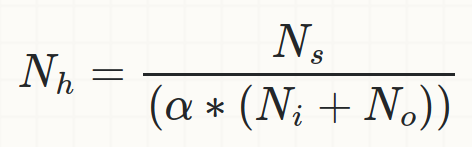

In [9]:
Image(filename="img/formula.png")

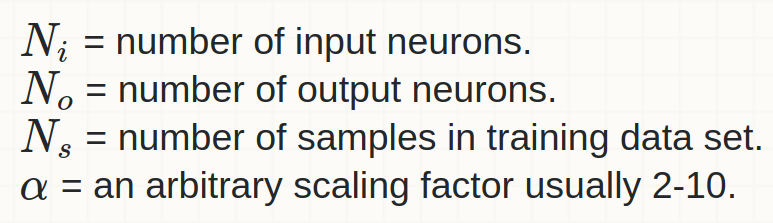

In [10]:
Image(filename="img/formulaDef.png")

In [11]:
print("All optimizers: ")
for c in dir(keras.optimizers):
    if c[0].isupper():
        print("-> " + c)

All optimizers: 
-> Adadelta
-> Adagrad
-> Adam
-> Adamax
-> K
-> Nadam
-> Optimizer
-> RMSprop
-> SGD
-> TFOptimizer


In [12]:
# Пробваме модела с RMSprop, защото е симпатяга за рекурентните невронни мрежи
# Try out the model with RMSprop optimizer, because he's good for recurrent neural networks

rmsprop = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=rmsprop)

In [13]:
# Нагласяме малко callbacks
# Setting up callbacks

def onTrainStart(logs):
    print("Train starting...")

def onTrainEnd(logs):
    print("Done training")

    model_json = model.to_json()
    with open("model/model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model/model.h5")

    print("Saved model")

In [14]:
# Нагласяне на няколко хиперпараметъра и трениране на модела
# Setting up hyperparameters and starting the train process

cbs = LambdaCallback(on_train_end=onTrainEnd, on_train_begin=onTrainStart)

model.fit(X, y, batch_size=100, epochs=60, callbacks=[cbs])

Train starting...
Epoch 1/60
196233/196233 [==============================] - 355s 2ms/step - loss: 2.0183
Epoch 2/60
196233/196233 [==============================] - 346s 2ms/step - loss: 1.6752
Epoch 3/60
196233/196233 [==============================] - 349s 2ms/step - loss: 1.5782
Epoch 4/60
196233/196233 [==============================] - 352s 2ms/step - loss: 1.5195
Epoch 5/60
196233/196233 [==============================] - 480s 2ms/step - loss: 1.4810
Epoch 6/60
196233/196233 [==============================] - 367s 2ms/step - loss: 1.4489
Epoch 7/60
196233/196233 [==============================] - 320s 2ms/step - loss: 1.4229
Epoch 8/60
196233/196233 [==============================] - 320s 2ms/step - loss: 1.4042
Epoch 9/60
196233/196233 [==============================] - 322s 2ms/step - loss: 1.3858
Epoch 10/60
196233/196233 [==============================] - 320s 2ms/step - loss: 1.3708
Epoch 11/60
196233/196233 [==============================] - 320s 2ms/step - loss: 1.3569
E

In [14]:
# Поглед върху структурата на модела
# Quick peek in the model's structure

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               133632    
_________________________________________________________________
dense_1 (Dense)              (None, 132)               17028     
_________________________________________________________________
activation_1 (Activation)    (None, 132)               0         
Total params: 150,660
Trainable params: 150,660
Non-trainable params: 0
_________________________________________________________________
